# Fraud via Social Network Analysis 

PaySim, a Mobile Money Payment Simulator The Mobile Money Payment Simulation case study is based on a real company that has developed a mobile money implementation that provides mobile phone users with the ability to transfer money between themselves using the phone as a sort of electronic wallet.

In this exercise, we will be using GRAPH THEORY as a means to explore the use of a network structures, its nodes and edges, as a means to analyze potential fraud.

# Load Data

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Load Libraries

In [2]:
data_df = pd.read_csv('data/archive.zip')

In [3]:
data_df.shape

(6362620, 11)

In [4]:
data_df.columns = [x.lower() for x in data_df.columns  ]

In [5]:
data_df.head()

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# Let's filter to only transactions with customers ('C') and not merchants ('M')
customers_only_df = data_df[data_df['nameorig'].str.contains('C') & data_df['namedest'].str.contains('C')]

# Let's further filter to transactions that are 'transfers' only
customers_only_df = customers_only_df[customers_only_df['type'] =='TRANSFER']

In [7]:
# let's rename our columns into a graph data structure. isfraud will be kept as a custom variable, while we use weight as variable for our amount transfered

edge_df = customers_only_df[['nameorig','namedest','amount','isfraud']]
edge_df.columns = ['source','target','weight','isfraud']


In [8]:

edge_df.head(1)

,source,target,weight,isfraud
2,C1305486145,C553264065,181.0,1


In [9]:
# We'll further filter the list of edges as we want to make this sample analysis to be manageable. If you have a powerful
# machine, feel free to increase this number or remove entirely.
edge_df = edge_df.head(500)
edge_df


,source,target,weight,isfraud
2,C1305486145,C553264065,181.00,1
19,C1670993182,C1100439041,215310.30,0
24,C1984094095,C932583850,311685.89,0
58,C1976401987,C1937962514,62610.80,0
78,C283039401,C1330106945,42712.39,0
...,...,...,...,...
5880,C602529144,C1636786811,1095802.84,0
5881,C1191985705,C1360767589,1408829.48,0
5882,C104893413,C451111351,704242.78,0
5883,C509065091,C214774813,2025330.83,0


# What is a Graph Network?

In mathematics, and more specifically in graph theory, a graph is a structure amounting to a set of objects in which some pairs of the objects are in some sense "related".

The objects correspond to mathematical abstractions called vertices (also called nodes or points) and each of the related pairs of vertices is called an edge (also called link or line).

In [10]:
# a utility function that takes a list of edges and converts it into a graph. 
# Normally, you create a list of nodes, then add the edges.
G = nx.from_pandas_edgelist(
    edge_df,
    edge_attr=True,
    create_using=nx.DiGraph(),
)

Here is an example of a node in our graph. In the context of our dataset, it's one customer.

If you print it's value, there's none because we haven't assigned anything. All our data are assigned to the edges because its defined by the transactions.

In [11]:
G.nodes['C1305486145'] 

{}

We can take a look at the edges that are connected to that node

In [12]:
G.edges('C1305486145')

OutEdgeDataView([('C1305486145', 'C553264065')])

We can also take a look at what the edge contains. This one has data, because our data are composed of transactions which labels of the amount transferred and whether it was marked as fraud or not.

In [13]:
G.get_edge_data('C1305486145', 'C553264065')

{'weight': 181.0, 'isfraud': 1}

If you take a look at the other node where we transfer the money, there's no edge going back because this is a directed node. connection only goes one way!

In [14]:
G.edges('C553264065')

OutEdgeDataView([])

# A directed graph
A directed graph is a set of vertices (nodes) connected by edges, with each node having a direction associated with it.

Edges are usually represented by arrows pointing in the direction the graph can be traversed.

In the example on the right, the graph can be traversed from vertex A to B, but not from vertex B to A.


In [15]:
# quick statistics from a Graph
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 741
Number of edges: 500
Average in degree:   0.6748
Average out degree:   0.6748


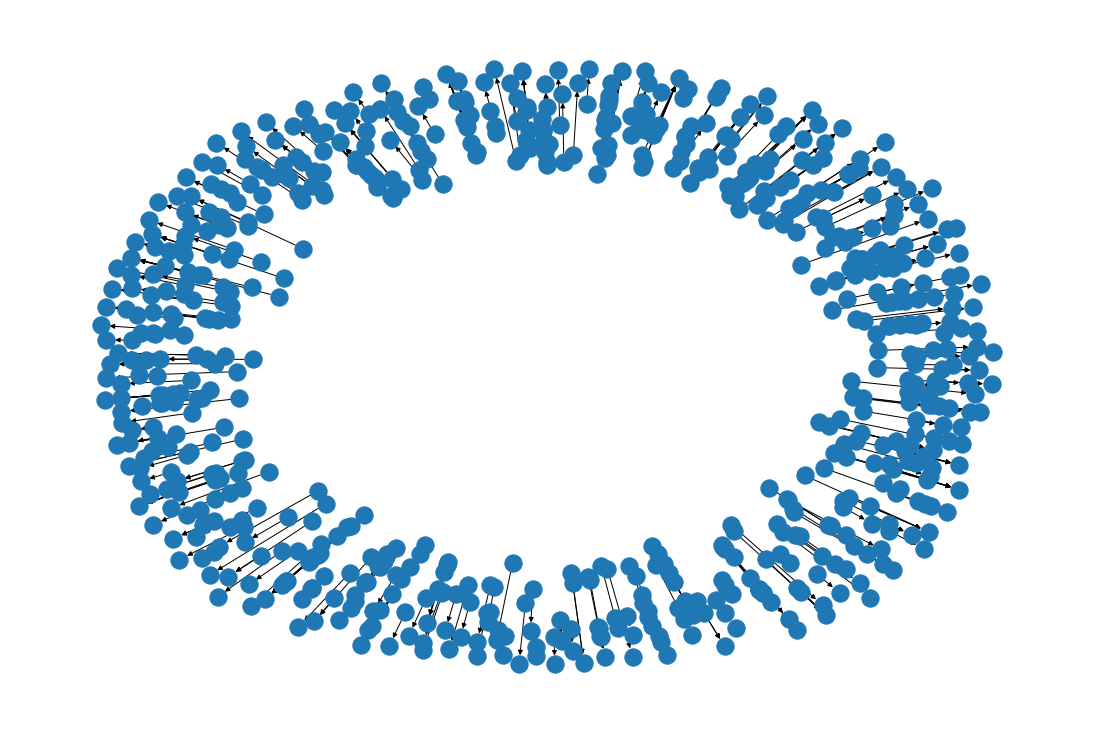

In [16]:
# visualize graph
# there are many ways to visualize a graph, there are also other libraries and languages that specialie in graph visualization.
pos = nx.spring_layout(G)
fig = plt.figure(figsize=(15, 10))
nx.draw(G, pos)
plt.show()


You can see nodes with arrows pointing to other nodes indicate that this is a directed graph and the arrows show how nodes (users) sent money to other users via transactions (edges) creating a connection.

# Marking Fraudsters
For purposes of this example, we will treat the 'receiver' of the payment transfers of fraud transactions to be the fraudster AKA scammers. We will mark them to show how they are related to the overall graph.

In [17]:
# Let's get the list of nodes in our network
for node in G.nodes:
    G.nodes[node]['is_scammer'] = 0 #let's initialize all nodes first as not a scammer first
    
for node in G.nodes:
    # Then we will go thru the process of checking their edges to see who they send money to. 
    # If the transaction is fraudulent then we will market the receiever as a scammer
    list_of_edges = G.edges(node)
    for edge in list_of_edges:
        # get the data of the edges
        edge_dict = G.get_edge_data(edge[0],edge[1])
        # assign the fraud flag to the RECEIVING end of the fraud transaction under the 'is_scammer'
        G.nodes[edge[1]]['is_scammer'] = edge_dict['isfraud']
        
        

In [18]:
G.nodes['C553264065'] #let's look at one of the receving nodes to see if the flag is present

{'is_scammer': 1}

Let's modify the code to color the nodes based on the value INSIDE of the node

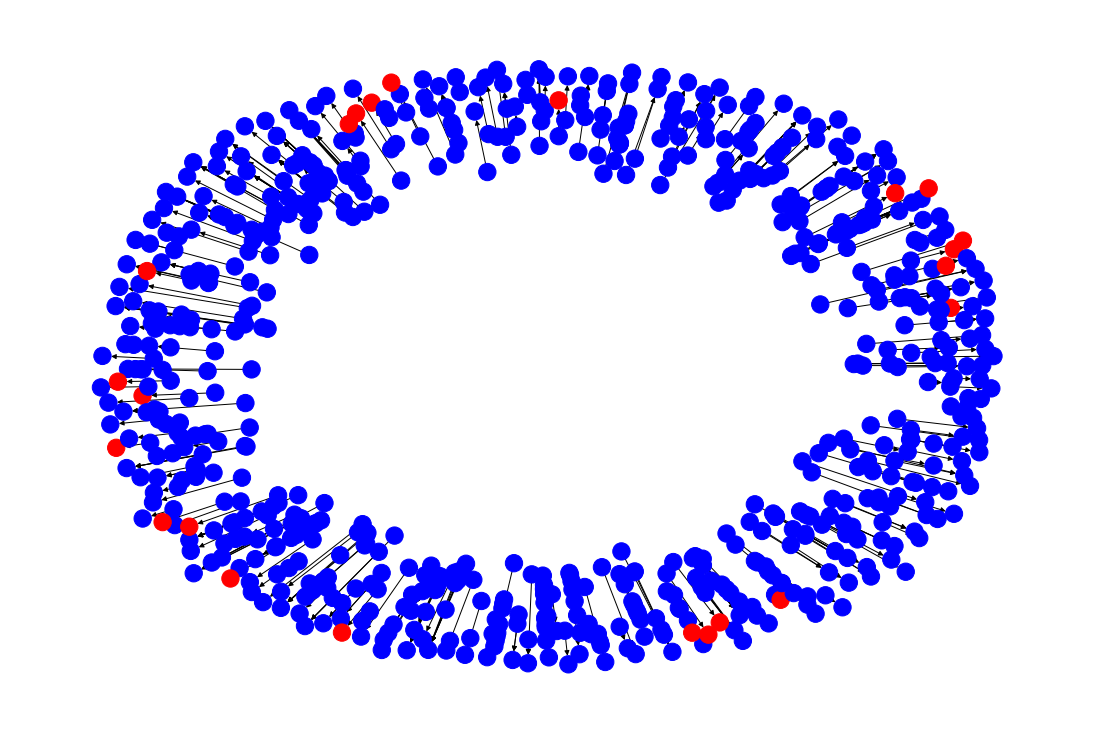

In [19]:
pos = nx.spring_layout(G)
fig = plt.figure(figsize=(15, 10))

# we will create a list of colors that is mapped against the nodes
# and generate the color of that node based on the value of 'is_scammer'
# thee 'values' variable is then sent to the draw function to color the scammer nodes
values = ['red' if G.nodes[node]['is_scammer'] else 'blue' for node in G.nodes()]
nx.draw(G, pos,node_color=values, with_labels=False, font_color='white') # labels will print the name of the node
plt.show()

# Graph Basics
Let's look at some standard metrics to review when analyzing graphs.

# Measures of Centrality
- A node's degree is the sum of its edges. the highly connected a node is, indicate a node's importance and a network's centrality. A node with large number of edges (or high degree) are known as hubs.
- Who are the important people, or hubs (nodes with large # of connections), in the network?

In [20]:
# Given a node it will count how many edges are connected to it
G.degree('C1590550415')

13

In [21]:
# Let's generate all node degree values and assign them as an attribute
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')
print(G.nodes['C1590550415'])

{'is_scammer': 0, 'degree': 13}


In [22]:
# What nodes have a value of more than 5 degrees
sorted(list(filter(lambda x: x[1]['degree']>5, G.nodes(data=True))), key=lambda x:x[1]['degree'], reverse=True)

[('C1590550415', {'is_scammer': 0, 'degree': 13}),
 ('C306206744', {'is_scammer': 0, 'degree': 10}),
 ('C1286084959', {'is_scammer': 0, 'degree': 8}),
 ('C564160838', {'is_scammer': 0, 'degree': 8}),
 ('C451111351', {'is_scammer': 0, 'degree': 8}),
 ('C453211571', {'is_scammer': 0, 'degree': 8}),
 ('C248609774', {'is_scammer': 0, 'degree': 8}),
 ('C1916720513', {'is_scammer': 0, 'degree': 8}),
 ('C392292416', {'is_scammer': 0, 'degree': 7}),
 ('C1899073220', {'is_scammer': 0, 'degree': 7}),
 ('C985934102', {'is_scammer': 0, 'degree': 7}),
 ('C1782113663', {'is_scammer': 0, 'degree': 7}),
 ('C665576141', {'is_scammer': 0, 'degree': 6}),
 ('C1789550256', {'is_scammer': 0, 'degree': 6}),
 ('C998351292', {'is_scammer': 0, 'degree': 6}),
 ('C716083600', {'is_scammer': 0, 'degree': 6}),
 ('C1883840933', {'is_scammer': 0, 'degree': 6}),
 ('C1262822392', {'is_scammer': 0, 'degree': 6})]

Closeness: Measures how close a node is to all other nodes. The more central a node is, the lower its closeness value. Another way to think of this metric is its a measure of how long it will take to spread information from the current node to all other nodes.

In [23]:
# function to compute for closeness
nx.closeness_centrality(G)

{'C1305486145': 0.0,
 'C553264065': 0.0013513513513513514,
 'C1670993182': 0.0,
 'C1100439041': 0.0013513513513513514,
 'C1984094095': 0.0,
 'C932583850': 0.006756756756756757,
 'C1976401987': 0.0,
 'C1937962514': 0.0013513513513513514,
 'C283039401': 0.0,
 'C1330106945': 0.0013513513513513514,
 'C207471778': 0.0,
 'C1761291320': 0.002702702702702703,
 'C1243171897': 0.0,
 'C783286238': 0.0013513513513513514,
 'C1376151044': 0.0,
 'C1749186397': 0.005405405405405406,
 'C873175411': 0.0,
 'C766572210': 0.002702702702702703,
 'C1443967876': 0.0,
 'C392292416': 0.00945945945945946,
 'C1449772539': 0.0,
 'C1590550415': 0.01756756756756757,
 'C926859124': 0.0,
 'C665576141': 0.008108108108108109,
 'C1603696865': 0.0,
 'C12905860': 0.0,
 'C1359044626': 0.005405405405405406,
 'C412788346': 0.0,
 'C1520267010': 0.0,
 'C908084672': 0.0,
 'C288306765': 0.0,
 'C1556867940': 0.0,
 'C1509514333': 0.0013513513513513514,
 'C1839168128': 0.0,
 'C1286084959': 0.010810810810810811,
 'C1495608502': 0.0,


Eigenvector centrality is similar to degrees but also cares about how many hubs a node is connected to. You can think of this as a person who is connected to the popular people of a network. Google's page rank is based on Eigenvector centrality of which a page's rank is determined by how many other pages point to it and how important those pages are.

In [24]:
# This might cause an error if the function can't successfully compute the eigenvector due to a small network. 
# nx.eigenvector_centrality(G) 

Betweenness centrality looks at the shortest paths, good for identifying key nodes serves as connection between clusters. While a node with a high no. of degrees is a hub, a node that is the shortest path between two clusters is called a broker. They act as a "bridge" between two (or more) communities/clusters.

NOTE: Some nodes will have high centrality, but low degrees - which means they are important brokers but are not hubs.

In [25]:
# function to compute for betweenness
nx.betweenness_centrality(G) 

{'C1305486145': 0.0,
 'C553264065': 0.0,
 'C1670993182': 0.0,
 'C1100439041': 0.0,
 'C1984094095': 0.0,
 'C932583850': 0.0,
 'C1976401987': 0.0,
 'C1937962514': 0.0,
 'C283039401': 0.0,
 'C1330106945': 0.0,
 'C207471778': 0.0,
 'C1761291320': 0.0,
 'C1243171897': 0.0,
 'C783286238': 0.0,
 'C1376151044': 0.0,
 'C1749186397': 0.0,
 'C873175411': 0.0,
 'C766572210': 0.0,
 'C1443967876': 0.0,
 'C392292416': 0.0,
 'C1449772539': 0.0,
 'C1590550415': 0.0,
 'C926859124': 0.0,
 'C665576141': 0.0,
 'C1603696865': 0.0,
 'C12905860': 0.0,
 'C1359044626': 0.0,
 'C412788346': 0.0,
 'C1520267010': 0.0,
 'C908084672': 0.0,
 'C288306765': 0.0,
 'C1556867940': 0.0,
 'C1509514333': 0.0,
 'C1839168128': 0.0,
 'C1286084959': 0.0,
 'C1495608502': 0.0,
 'C835773569': 0.0,
 'C843299092': 0.0,
 'C605982374': 0.0,
 'C1225616405': 0.0,
 'C1494346128': 0.0,
 'C564160838': 0.0,
 'C722417467': 0.0,
 'C451111351': 0.0,
 'C753631393': 0.0,
 'C716157500': 0.0,
 'C697508322': 0.0,
 'C1688019098': 0.0,
 'C201677908': 0

Graph density represents the ratio between the edges present in a graph and the maximum number of edges that the graph can contain also known as "how closely knit the network is"

In [26]:
# function to compute for network density
nx.density(G)

0.000911843017106175

# Centrality versus centralization
- Centrality is a node level metric; each node has a centrality score representing it’s position within the network
- Centralization is a group level metric indicating the extent to which the network is dominated by one or a few nodes

# An Undirected Graph
An undirected graph, the edges are bidirectional with no direction associated with them.

Hence, the graph can be traversed in either direction. The absence of an arrow tells us that the graph is undirected.


# Undirected Graph Metrics


There are some metrics that only work in undirected Graphs, so let's re-create the graph to reflect this. We'll consider all connection as working both ways for this.

In [27]:
# Let's recreate our graph as undirected for the following exercises

G_undirected = nx.from_pandas_edgelist(
    edge_df,
    edge_attr=True,
    create_using=nx.Graph(),
)

Diameter is the length of the path between the two nodes that are furthest apart. The measure is designed to give you a sense of the network’s overall size, the distance from one end of the network to another.

In [28]:
# unfortunately this might cause an error if our network is not fully connected (there are some components that are not connected)
# nx.diameter(G_undirected)

In [29]:
# This is a good test to see if your graph is fully connected
nx.is_connected(G_undirected)

False

# A connected graph has just one component

In [30]:
# What components do you have?
components = nx.connected_components(G_undirected)
list(components) # these are the list of "sub networks" in your graph

[{'C1305486145', 'C553264065'},
 {'C1100439041', 'C1670993182'},
 {'C1648700617',
  'C1731137986',
  'C1855297340',
  'C1984094095',
  'C538375433',
  'C932583850'},
 {'C1937962514', 'C1976401987'},
 {'C1330106945', 'C283039401'},
 {'C1761291320', 'C207471778', 'C2134639513'},
 {'C1243171897', 'C783286238'},
 {'C1376151044', 'C1749186397', 'C2016142571', 'C989440614', 'C992743048'},
 {'C1603696865', 'C766572210', 'C873175411'},
 {'C1135935001',
  'C1369885738',
  'C1443967876',
  'C332365138',
  'C392292416',
  'C573102881',
  'C908084672',
  'C973604791'},
 {'C1057507014',
  'C106297322',
  'C1321115948',
  'C1449772539',
  'C1495608502',
  'C1520267010',
  'C1590550415',
  'C1649847375',
  'C2007599722',
  'C396918327',
  'C412788346',
  'C476579021',
  'C837923432',
  'C843299092'},
 {'C1419332030',
  'C1758060579',
  'C355885103',
  'C555943503',
  'C665576141',
  'C695248316',
  'C926859124'},
 {'C1055601039', 'C12905860', 'C1359044626', 'C288306765', 'C835773569'},
 {'C1509514333

In [31]:
# what's the largest of the components?
largest_component = max(nx.connected_components(G_undirected), key=len)
print("size of largest: ",len(largest_component))
list(largest_component)

size of largest:  14


['C1321115948',
 'C106297322',
 'C1495608502',
 'C396918327',
 'C1057507014',
 'C1520267010',
 'C412788346',
 'C837923432',
 'C1649847375',
 'C2007599722',
 'C1590550415',
 'C1449772539',
 'C843299092',
 'C476579021']

In [32]:
# what's the diameter of this component?
subgraph = G_undirected.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

Network diameter of largest component: 2


There should be no larger diameter for the other components, as this is already the largest of the components.

Triadic closure is a metric that tries to estimate that if two nodes are connected to a 3rd node, most probably these two nodes might have a 'hidden' connection. It's similar to how in life, two people can know a 3rd person thru different circumstances. #smallworld

Triadic closure is measured via transitivity which is a measure between 0 and 1. It is similar to density in which it tries to measure how connected a network is in terms of a ratio against possible connections - that there is a "likelihood" that a connection exists that currently is not captured in the graph.

In [33]:
# if the network is not highly connected it might show a low value
triadic_closure = nx.transitivity(G_undirected)
print("Triadic closure:", triadic_closure) 

Triadic closure: 0


# What is community detection?

In the study of complex networks, a network is said to have community structure if the nodes of the network can be easily grouped into (potentially overlapping) sets of nodes such that each set of nodes is densely connected internally. In the particular case of non-overlapping community finding, this implies that the network divides naturally into groups of nodes with dense connections internally and sparser connections between groups. But overlapping communities are also allowed. The more general definition is based on the principle that pairs of nodes are more likely to be connected if they are both members of the same community(ies), and less likely to be connected if they do not share communities. 

# How is it different from clustering?
The difference is minor in the sense that community detection is the detection of "tightly related groups" in a network, which indicates that it only exists in a graph context. On the other hand, clusters can be seen applied in non-graph contexts where in instead of relationships, attributes/features are used to compute for "distances".

# Community detection using Greedy Modularity Maximization
Greedy modularity maximization begins with each node in its own community and joins the pair of communities that most increases modularity until no such pair exists or until number of communities n_communities is reached.

Note: There are a lot of algorithms that can be used to 'detect' communities in networks.

# What is modularity in community detection?
Modularity is a measure of the structure of networks or graphs which measures the strength of division of a network into modules (also called groups, clusters or communities). Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules.

In [34]:
# Note that community detection is very hard to do in directed graphs, so we will use our undirected for this
commlist = nx.algorithms.community.greedy_modularity_communities(G_undirected)
commlist

[frozenset({'C1057507014',
            'C106297322',
            'C1321115948',
            'C1449772539',
            'C1495608502',
            'C1520267010',
            'C1590550415',
            'C1649847375',
            'C2007599722',
            'C396918327',
            'C412788346',
            'C476579021',
            'C837923432',
            'C843299092'}),
 frozenset({'C1153933106',
            'C1238013097',
            'C1418310135',
            'C1502971166',
            'C1787987889',
            'C1928117427',
            'C1928312257',
            'C306206744',
            'C361571676',
            'C409007038',
            'C706665172'}),
 frozenset({'C1172535934',
            'C1494346128',
            'C1540894701',
            'C1568949719',
            'C1950136544',
            'C2010070923',
            'C564160838',
            'C584157293',
            'C684407333'}),
 frozenset({'C1306429814',
            'C1618683794',
            'C2144067911',
        

In [35]:
# How many communities did we detect?
len(commlist)

241

In [36]:
# assign community id to each node

modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(commlist): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information on to the nodes
nx.set_node_attributes(G_undirected, modularity_dict, 'modularity')

# note that what we are storing is NOT a modularity score, but the community number from the detection algorithm

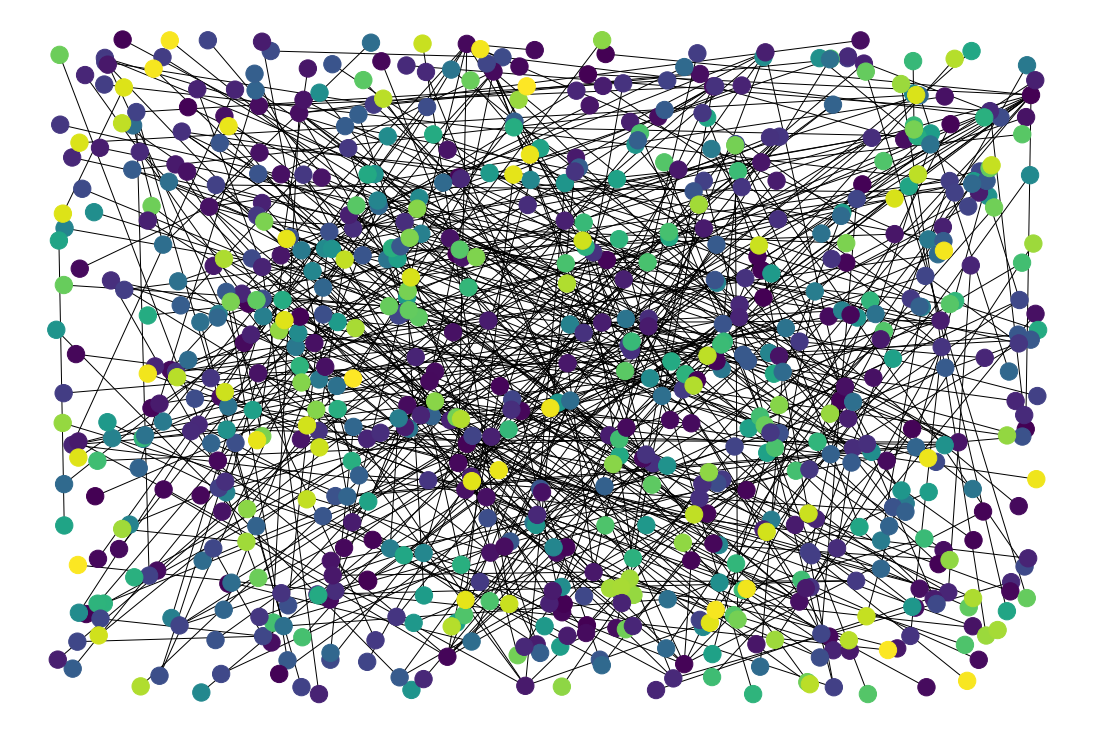

In [37]:
# Let's use a color map and apply one color per community so all nodes in a community have the same color
node_cmap1 = [[v][0]['modularity'] for _,v in G_undirected.nodes(data=True)]

pos = nx.random_layout(G_undirected)
fig = plt.figure(figsize=(15, 10))
nx.draw(G_undirected, pos, cmap= plt.get_cmap('viridis'), node_color=node_cmap1,edge_color="black",width=1)
plt.show()

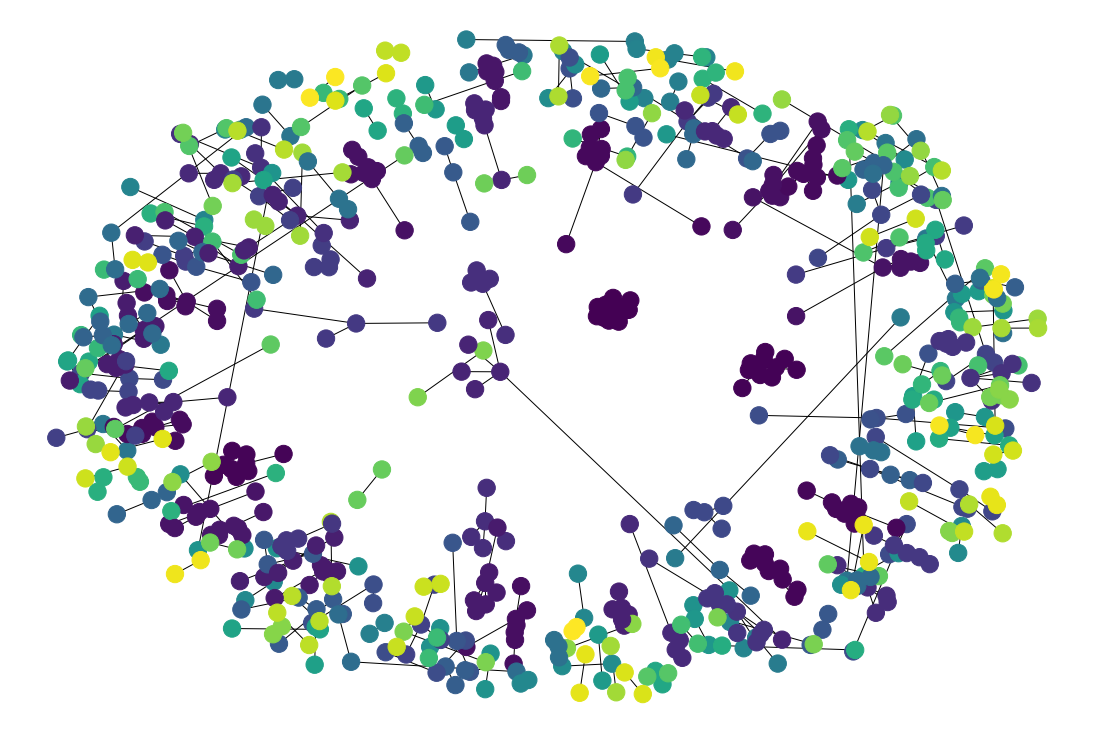

In [38]:
# Let's try a different way to visualize
node_cmap1 = [[v][0]['modularity'] for _,v in G_undirected.nodes(data=True)]

pos = nx.spring_layout(G_undirected, k =5)
fig = plt.figure(figsize=(15, 10))
nx.draw(G_undirected, pos, cmap= plt.get_cmap('viridis'), node_color=node_cmap1,edge_color="black",width=1)
plt.show()

# Let's pick out one community and see how it looks like

In [39]:
# Let's look at the  top 10 communities
for idx,i in enumerate(nx.algorithms.community.greedy_modularity_communities(G_undirected)):
    print("community: ",idx, "size: ",len(i))
    if(idx==9):
        break

community:  0 size:  14
community:  1 size:  11
community:  2 size:  9
community:  3 size:  9
community:  4 size:  9
community:  5 size:  9
community:  6 size:  9
community:  7 size:  9
community:  8 size:  8
community:  9 size:  8


In [40]:
# let's zoom in on the first one
nx.algorithms.community.greedy_modularity_communities(G_undirected)[0]

frozenset({'C1057507014',
           'C106297322',
           'C1321115948',
           'C1449772539',
           'C1495608502',
           'C1520267010',
           'C1590550415',
           'C1649847375',
           'C2007599722',
           'C396918327',
           'C412788346',
           'C476579021',
           'C837923432',
           'C843299092'})

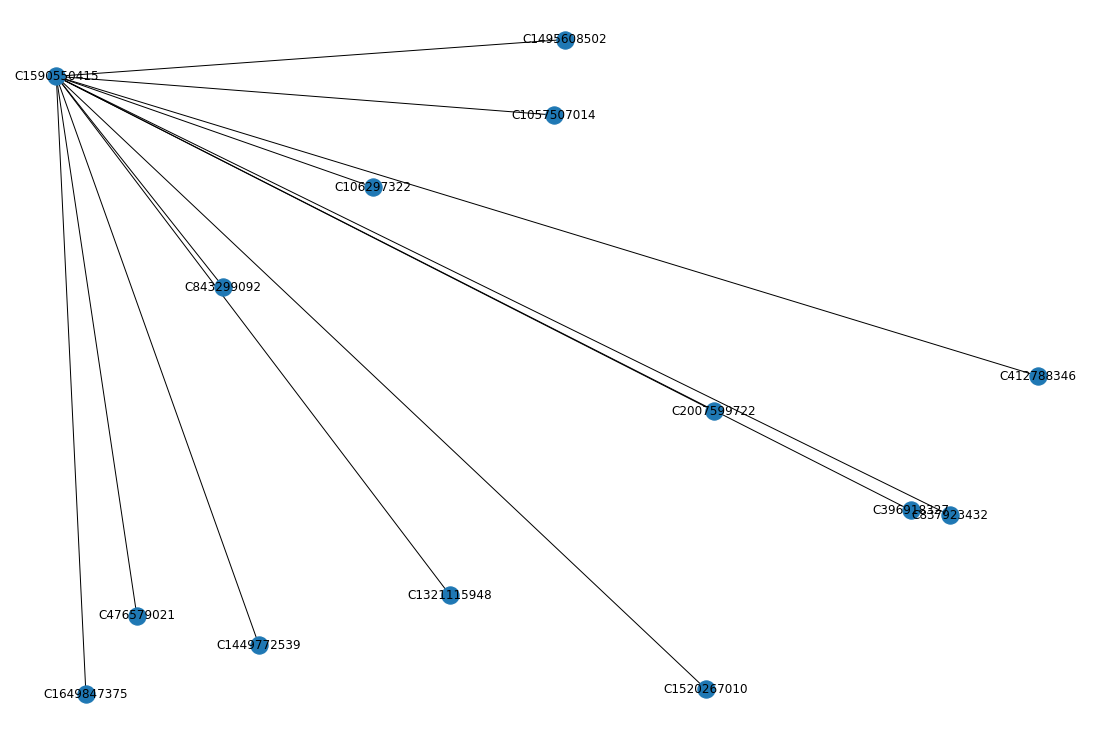

In [41]:
# let's visualize the sub graph for fun
comm1 = G_undirected.subgraph(nx.algorithms.community.greedy_modularity_communities(G_undirected)[0])
fig = plt.figure(figsize=(15, 10))
pos = nx.random_layout(G_undirected)
nx.draw(comm1, pos, with_labels=True)
plt.show()

In [42]:
# can we pick a node and inspect it's attributes
G_undirected.nodes['C1590550415']

{'modularity': 0}

In [43]:
# what is its degree?
G_undirected.degree('C1590550415')

13

In [44]:
# what edges / connections did this node have?

G_undirected.edges('C1590550415')

EdgeDataView([('C1590550415', 'C1449772539'), ('C1590550415', 'C412788346'), ('C1590550415', 'C1520267010'), ('C1590550415', 'C1495608502'), ('C1590550415', 'C843299092'), ('C1590550415', 'C476579021'), ('C1590550415', 'C106297322'), ('C1590550415', 'C396918327'), ('C1590550415', 'C1057507014'), ('C1590550415', 'C2007599722'), ('C1590550415', 'C1321115948'), ('C1590550415', 'C1649847375'), ('C1590550415', 'C837923432')])

In [45]:
# Let's sample one edge
list(G_undirected.edges('C1590550415'))[0]

('C1590550415', 'C1449772539')

In [46]:
# Let's look at their transaction details
G_undirected.get_edge_data('C1590550415', 'C1449772539')

{'weight': 379856.23, 'isfraud': 0}

In [47]:
# Let's look at everyone else's details
for x, y in list(G_undirected.edges('C1590550415')):
    print(x,"->",y,"attributes: ",G_undirected.get_edge_data(x, y))

C1590550415 -> C1449772539 attributes:  {'weight': 379856.23, 'isfraud': 0}
C1590550415 -> C412788346 attributes:  {'weight': 761507.39, 'isfraud': 0}
C1590550415 -> C1520267010 attributes:  {'weight': 1429051.47, 'isfraud': 0}
C1590550415 -> C1495608502 attributes:  {'weight': 1724887.05, 'isfraud': 0}
C1590550415 -> C843299092 attributes:  {'weight': 581294.26, 'isfraud': 0}
C1590550415 -> C476579021 attributes:  {'weight': 1538200.39, 'isfraud': 0}
C1590550415 -> C106297322 attributes:  {'weight': 2421578.09, 'isfraud': 0}
C1590550415 -> C396918327 attributes:  {'weight': 1457213.54, 'isfraud': 0}
C1590550415 -> C1057507014 attributes:  {'weight': 2545478.01, 'isfraud': 0}
C1590550415 -> C2007599722 attributes:  {'weight': 2061082.82, 'isfraud': 0}
C1590550415 -> C1321115948 attributes:  {'weight': 1193410.46, 'isfraud': 0}
C1590550415 -> C1649847375 attributes:  {'weight': 1440296.14, 'isfraud': 0}
C1590550415 -> C837923432 attributes:  {'weight': 1545681.21, 'isfraud': 0}


We didn't sample a community with a scammer because our data only has 1 to 1 fraud transactions. But hopefully this has been enough to illustrate how to explore communities within a graph. 

In [48]:
edge_df[edge_df['isfraud']==1].groupby(['target','source']).count()

,,weight,isfraud
target,source,,
C1002031672,C1247938090,1,1
C1136419747,C1364127192,1,1
C116289363,C1872047468,1,1
C118648358,C1134864869,1,1
C1191544932,C1844941220,1,1
C1384210339,C669700766,1,1
C162114152,C1409933277,1,1
C1662235713,C2025652936,1,1
C1807010830,C383882703,1,1


# How can this be used for fraud?

Graph networks can be used to do Social network analysis with which we can leverage to learn more about customers’ behavior, not just in terms of individual usage but mostly in relation to the customers’ connections.
Using community detection we can see how they create communities according to how they send and receive money. 

By performing community detection, we are able to recognize groups of customers with unexpected behavior or groupings in terms of usage and also in regard to types of social structures. Outliers groups might be pointed out as suspicious
communities in terms of fraud events, delivering a relevant knowledge about possible leakages of money (or information, depending on your use case).


In [49]:
# Let's find the edges / transactions that had fraud activities
fraud_txn = []
fraud_nodes = []
for x,y in list(G_undirected.edges()):
    if(G_undirected.get_edge_data(x, y)['isfraud']==1):
        fraud_txn.append((x, y))
        fraud_nodes.append(x)
        fraud_nodes.append(y)
        
fraud_nodes = list(set(fraud_nodes)) # remove potential duplicates
print("fraudulent edges: ", fraud_txn)
print("fraudulent nodes: ", fraud_nodes)


fraudulent edges:  [('C1305486145', 'C553264065'), ('C1420196421', 'C972765878'), ('C137533655', 'C1848415041'), ('C1334405552', 'C431687661'), ('C1364127192', 'C1136419747'), ('C669700766', 'C1384210339'), ('C1872047468', 'C116289363'), ('C1093223281', 'C2063275841'), ('C1440057381', 'C268086000'), ('C140702728', 'C634210724'), ('C1375503918', 'C234430897'), ('C1134864869', 'C118648358'), ('C1247938090', 'C1002031672'), ('C7162498', 'C945327594'), ('C2047521920', 'C449261773'), ('C540962910', 'C2127862399'), ('C17222024', 'C410033330'), ('C1844941220', 'C1191544932'), ('C1409933277', 'C162114152'), ('C383882703', 'C1807010830'), ('C1775746074', 'C746009679'), ('C2025652936', 'C1662235713'), ('C864622150', 'C41792607'), ('C457596841', 'C1956477953')]
fraudulent nodes:  ['C1093223281', 'C746009679', 'C1844941220', 'C864622150', 'C972765878', 'C1191544932', 'C2063275841', 'C1334405552', 'C17222024', 'C1956477953', 'C1134864869', 'C116289363', 'C1440057381', 'C945327594', 'C1384210339', '

In [50]:
# Let's use this list to filter out the communities connected to these nodes

fraud_comm_list = []
for x in fraud_nodes:
   
    fraud_comm_list.append(G_undirected.nodes[x]['modularity'])
fraud_comm_list = list(set(fraud_comm_list)) # remove duplicates
print(fraud_comm_list)

[139, 159, 162, 165, 176, 180, 189, 195, 196, 203, 206, 207, 80, 210, 215, 92, 225, 99, 227, 233, 105, 110, 238, 116]


In [51]:
# let's use the modularity # to retrieve from our community list the members of these sub communities
for x in fraud_comm_list:
    print(commlist[x])

frozenset({'C1384210339', 'C669700766'})
frozenset({'C2063275841', 'C1093223281'})
frozenset({'C268086000', 'C1440057381'})
frozenset({'C634210724', 'C140702728'})
frozenset({'C234430897', 'C1375503918'})
frozenset({'C118648358', 'C1134864869'})
frozenset({'C1002031672', 'C1247938090'})
frozenset({'C945327594', 'C7162498'})
frozenset({'C449261773', 'C2047521920'})
frozenset({'C540962910', 'C2127862399'})
frozenset({'C17222024', 'C410033330'})
frozenset({'C1844941220', 'C1191544932'})
frozenset({'C54440148', 'C116289363', 'C1872047468'})
frozenset({'C162114152', 'C1409933277'})
frozenset({'C383882703', 'C1807010830'})
frozenset({'C1305486145', 'C553264065'})
frozenset({'C746009679', 'C1775746074'})
frozenset({'C972765878', 'C1420196421'})
frozenset({'C1662235713', 'C2025652936'})
frozenset({'C41792607', 'C864622150'})
frozenset({'C1848415041', 'C137533655'})
frozenset({'C1334405552', 'C431687661'})
frozenset({'C457596841', 'C1956477953'})
frozenset({'C1136419747', 'C1364127192'})


Identified communities have a high chance of being connected to each other even though it is not captured in our data. If node A and node B are connected to node C, there is a high "LIKELIHOOD" that both node A and B are connected. 

Please note that we are talking in likelihoods and not certainties. Community detection could help in discovering these potential hidden "fraud rings" after which using measures of centralities like degrees and betweenness could help identify the key nodes in a fraud network or which nodes are just "small players".

The potential big and small players can then be further scrutinized by zooming in their transactions and information, applying traditional methods to validate their authenticity.

# Can I bring back graph statistics for use in standard modeling?

Yes. Here is an example of generating some graph statistics and bringing them back into a dataframe

In [52]:
# This is how to convert your edges back into a dataframe
graph_edgelist_df = nx.to_pandas_edgelist(G)
graph_edgelist_df
# to add more information to this, just assign more information to your edges
# edges in networkx are similar to nodes that they act like dictionaries

,source,target,isfraud,weight
0,C1305486145,C553264065,1,181.00
1,C1670993182,C1100439041,0,215310.30
2,C1984094095,C932583850,0,311685.89
3,C1976401987,C1937962514,0,62610.80
4,C283039401,C1330106945,0,42712.39
...,...,...,...,...
495,C602529144,C1636786811,0,1095802.84
496,C1191985705,C1360767589,0,1408829.48
497,C104893413,C451111351,0,704242.78
498,C509065091,C214774813,0,2025330.83


In [53]:
# If you want to create a dataframe based on your graph nodes and its attributes
graph_node_df = pd.DataFrame.from_dict(G.nodes, orient='index').reset_index()
# Since nodes are essentially a list of dictionaries, pandas can process them using helper function
graph_node_df

,index,is_scammer,degree
0,C1305486145,0,1
1,C553264065,1,1
2,C1670993182,0,1
3,C1100439041,0,1
4,C1984094095,0,1
...,...,...,...
736,C1636786811,0,1
737,C1191985705,0,1
738,C104893413,0,1
739,C509065091,0,1


# Lesson Synthesis
- How can you use graph metrics such as density, transitivity, and diameter in analyzing fraud?
- How does knowing which nodes have high degrees, eigvenvector, betweenness, and closeness measures help in analyzing importance of a node?
- How does visualization help in graph analysis?
- How do you compare the pros and cons of using graph and non-graph analysis?
- Besides fraud, what other ways can social network analysis be beneficial as a form of analysis?

# References
- Graph Theory Lectures https://medium.com/basecs/a-gentle-introduction-to-graph-theory-77969829ead8
- Introduction to networkx https://medium.com/analytics-vidhya/a-gentle-introduction-to-networkx-with-python-21c29419d28a
- scikit-network: Alternative graph libary https://scikit-network.readthedocs.io/en/latest/|